In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima_model import ARIMA

In [2]:
# configure df options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:,.5f}'.format

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Read samples from one station

In [4]:
station_code = 'SONDOC'

#### Read true raw samples

In [5]:
df = pd.read_csv('../../dataset/final/bentre-cleaned.csv', parse_dates=['date'])

In [6]:
df.set_index('date', inplace=True)

In [7]:
df = df[df['code'] == station_code]

In [8]:
# How samples distributed
df.groupby(df.index.year).count()

,code,min,max,x,y,cm
date,,,,,,
2002,181,181,181,181,181,181
2003,181,181,181,181,181,181
2004,182,182,182,182,182,182
2005,181,181,181,181,181,181
2006,181,181,181,181,181,181
2007,181,181,181,181,181,181
2008,182,182,182,182,182,182
2009,181,181,181,181,181,181
2010,181,181,181,181,181,181


##### From 2002 to 2010, samples are completed for dry seasons: 181 for normal years; 182 for leap years
#### 2011 and 2018 have more samples than other years
#### 2017 has no samples at all

#### Reread prepared samples

In [9]:
df = pd.read_csv(f'../../dataset/final/stations_all/{station_code}.csv', parse_dates=['date'])

In [10]:
# set index to time-series based 'date'
df.set_index('date', inplace=True)

In [11]:
df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=6209, freq=None)

In [12]:
# can not set index frequency to D - daily due to missing discontinuous timestamps in the dataset
df.index.freq = 'D'
df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=6209, freq='D')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6209 entries, 2002-01-01 to 2018-12-31
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   code    6209 non-null   object 
 1   min     6209 non-null   float64
 2   max     6209 non-null   float64
dtypes: float64(2), object(1)
memory usage: 194.0+ KB


In [14]:
# sort by date index
df.sort_index(inplace=True)

df.head()

,code,min,max
date,,,
2002-01-01,SONDOC,0.10000,0.30000
2002-01-02,SONDOC,0.10000,0.40000
2002-01-03,SONDOC,0.20000,0.40000
2002-01-04,SONDOC,0.20000,0.50000
2002-01-05,SONDOC,0.10000,0.60000


### ARIMA Self Help

In [15]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array_like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array_like, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |

### Split training and test sets  
Use 2018 as test set for now. When 2019 data can be collected, 2019 samples will be used for testing and 2020 data can be considered as evaluation

In [16]:
test_year = 2018

In [17]:
train_df = df[df.index.year < test_year]
train_df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=5844, freq='D')

In [18]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
min,"5,844.00000",1.17801,2.29743,0.01000,0.01000,0.01000,1.40000,14.90000
max,"5,844.00000",2.89067,4.51824,0.01000,0.01000,0.01000,5.10000,27.40000


In [19]:
test_df = df[df.index.year >= test_year]
test_df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=365, freq='D')

In [20]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
min,365.00000,1.19222,2.30773,0.01000,0.01000,0.01000,0.80000,8.90000
max,365.00000,1.77995,3.23592,0.01000,0.01000,0.01000,1.70000,12.10000


### Try out some simpler models

In [21]:
value_field = 'max'

# Annual
season_length = test_df.shape[0]  # same length of test data

# seasonal adjustment
adjustment = 'additive'
#adjustment = 'multiplicative'

1. Holt-Winters method via Exponential Smoothing

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(train_df[value_field], 
                                trend=adjustment, seasonal=adjustment, 
                                seasonal_periods=season_length).fit()

In [23]:
hw_prediction = hw_model.forecast(season_length)

In [24]:
hw_prediction.head(10)

2018-01-01   0.44085
2018-01-02   0.32167
2018-01-03   0.52030
2018-01-04   0.69532
2018-01-05   0.57502
2018-01-06   0.53041
2018-01-07   0.43866
2018-01-08   0.36867
2018-01-09   0.27458
2018-01-10   0.24242
Freq: D, dtype: float64

In [25]:
hw_prediction.tail(10)

2018-12-22   -0.16769
2018-12-23   -0.16115
2018-12-24   -0.14612
2018-12-25   -0.12001
2018-12-26   -0.09560
2018-12-27   -0.08299
2018-12-28   -0.03997
2018-12-29    0.02489
2018-12-30    0.10144
2018-12-31    0.01805
Freq: D, dtype: float64

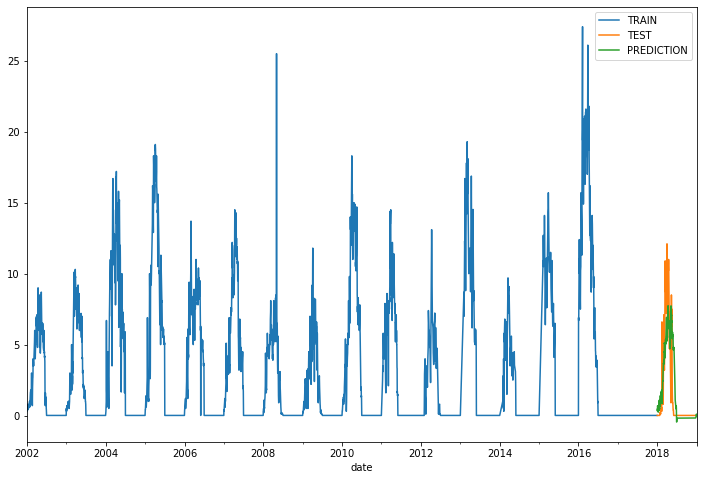

In [27]:
# plot prediction vs. true values
train_df[value_field].plot(legend=True, label='TRAIN')
test_df[value_field].plot(legend=True, label='TEST', figsize=(12,8))
hw_prediction.plot(legend=True, label='PREDICTION');

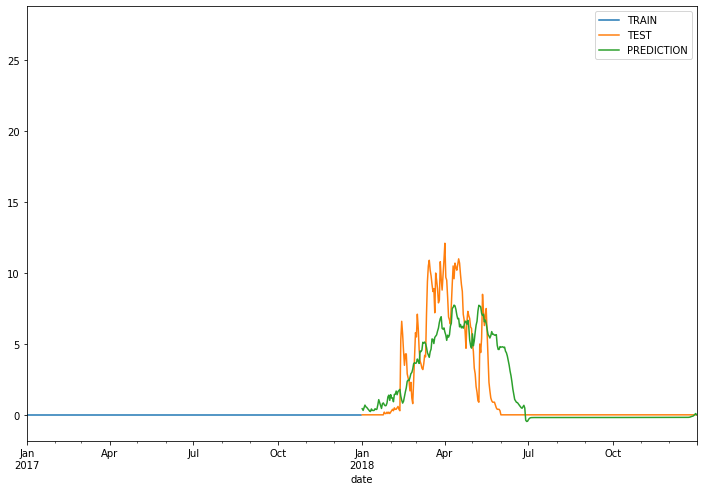

In [28]:
# plot prediction vs. true values on test set (zoomed version)
train_df[value_field].plot(legend=True, label='TRAIN')
test_df[value_field].plot(legend=True, label='TEST', figsize=(12,8))
hw_prediction.plot(legend=True, label='PREDICTION', xlim=[f'{test_year - 1}-01-01', f'{test_year}-12-31']);

##### Missing 2017 samples is critically effected the prediction!!!

#### Evaluating Prediction against test set

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [30]:
test_df[value_field].describe()

count   365.00000
mean      1.77995
std       3.23592
min       0.01000
25%       0.01000
50%       0.01000
75%       1.70000
max      12.10000
Name: max, dtype: float64

In [31]:
hw_prediction.describe()

count   365.00000
mean      1.75519
std       2.60221
min      -0.45511
25%      -0.17749
50%      -0.08299
75%       4.38806
max       7.73906
dtype: float64

The average of test data value is: 1.78  
The average of prediction value is: 1.76

In [32]:
mae = mean_absolute_error(test_df[value_field], hw_prediction)

mae

1.1640935126012508

In [33]:
mse = mean_squared_error(test_df[value_field], hw_prediction)

mse

3.841163374045708

In [34]:
rmse = np.sqrt(mse)

rmse

1.9598886126629003

##### Holt-Winters prediction is not that bad  
rmse = 1.96 vs. test data STD = 3.24: Error in form of RMSE is about 60% of Test STD => GOOD ENOUGH

#### Forecasting future

In [35]:
# re-train model on the full dataset of the station
hw_final_model = ExponentialSmoothing(df[value_field], 
                                      trend=adjustment, 
                                      seasonal=adjustment, 
                                      seasonal_periods=season_length).fit()

In [36]:
# predict for 2019
hw_next_year_forecast = hw_final_model.forecast(season_length)

hw_next_year_forecast.head()

2019-01-01   0.41451
2019-01-02   0.26117
2019-01-03   0.43728
2019-01-04   0.58124
2019-01-05   0.44990
Freq: D, dtype: float64

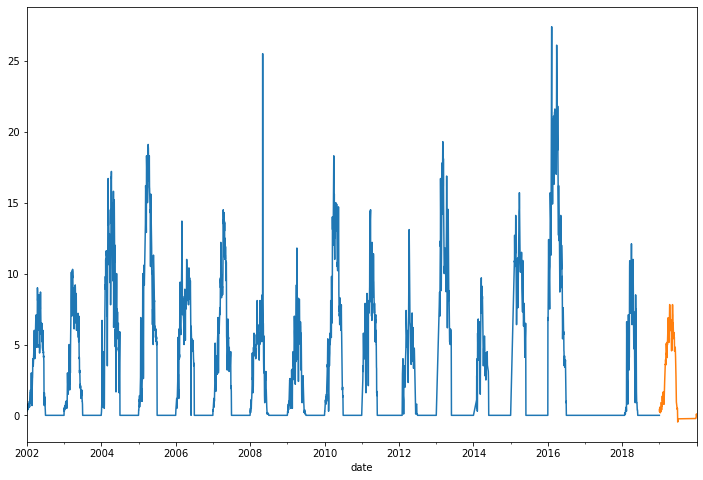

In [37]:
# plot
df[value_field].plot(figsize=(12,8))
hw_next_year_forecast.plot();

2. Other simple model goes here

### ARIMA models

1. Using AR component

In [38]:
from statsmodels.tsa.ar_model import AR, ARResults

In [41]:
model = AR(train_df[value_field])

ARfit = model.fit(method='mle', ic='t-stat')

lags = ARfit.k_ar

print(f'Lag: {lags}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 33
Coefficients:
const      0.04591
L1.max     0.88262
L2.max     0.07813
L3.max    -0.00207
L4.max    -0.00578
L5.max    -0.01909
L6.max     0.00053
L7.max     0.01520
L8.max    -0.01542
L9.max     0.03611
L10.max   -0.01989
L11.max   -0.00933
L12.max    0.05001
L13.max    0.01523
L14.max    0.01829
L15.max   -0.03313
L16.max    0.03564
L17.max   -0.03353
L18.max    0.01409
L19.max    0.00554
L20.max   -0.01310
L21.max   -0.00151
L22.max    0.01384
L23.max    0.02806
L24.max   -0.02292
L25.max   -0.03434
L26.max    0.03986
L27.max   -0.01198
L28.max    0.03404
L29.max   -0.00921
L30.max    0.02663
L31.max    0.00553
L32.max   -0.01209
L33.max   -0.07205
dtype: float64


In [51]:
# general formula to calculate time periods for obtaining predictions
start = len(train_df)
end = start + len(test_df) - 1

In [52]:
ARprediction = ARfit.predict(start=start, end=end).rename(f'AR({lags}) Prediction')

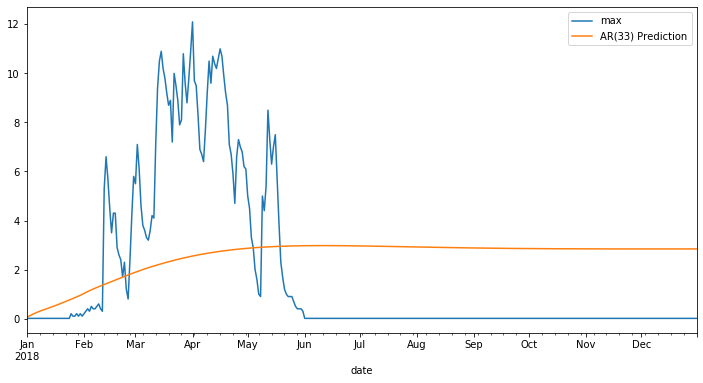

In [53]:
test_df[value_field].plot(legend=True)
ARprediction.plot(legend=True,figsize=(12,6));

AR failed completely. Not surprised!